The code in this notebook loads the saved weights of the Bi-LSTM+CNN model and makes predictions on the test set.

In [1]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Checking the RAM allotted
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print("\n")

#Checking the GPU allotted
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Your runtime has 13.6 gigabytes of available RAM



Wed Dec 15 17:49:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                    

Let's import the libraries required at this stage.

In [3]:
import pandas as pd
import numpy as np
import sys
import re
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import time
from prettytable import PrettyTable

In [4]:
import operator
import json
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from scipy import spatial
import os
import pickle

#### Loading the dataset that has been saved as a JSON file

In [6]:
#The whole path will have to be specified for colab
basePath = "/content/drive/My Drive/Dissertation/Classification Models/Bi-LSTM+CNN/"
news_df = pd.read_json(basePath + "IndianNews_Dataset_for_glove_embeddings.json", orient ='split', compression = 'infer')
news_df.shape

(25524, 7)

#### Loading the updated glove embeddings

In [7]:
#Loading the pickled embeddings:
with open(basePath + 'updated_embeddings.pickle', 'rb') as handle:
    glove_embeddings_dict = pickle.load(handle)

In [8]:
#Checking the memory size of the glove embeddings
print("Memory size of the embeddings is {:.2f} GB".format(sys.getsizeof(glove_embeddings_dict)/(1024*1024)))

Memory size of the embeddings is 80.00 GB


# Data Preparation

## Converting the target column to numbers

In [9]:
#Creating a dictionary to change the values of the Ideology column
#Note that the number have to start from 0 to use the keras to_categorical() function
id_dict = {'centre': 0, 'left': 1, 'right': 2}

In [10]:
#Checking the values in this column before mapping
news_df['Ideology'].unique()

array(['centre', 'left', 'right'], dtype=object)

In [11]:
#Using the dictionary to change the values in the column
news_df['Ideology'] = news_df['Ideology'].map(id_dict)
news_df['Ideology'].unique()

array([0, 1, 2])

## Splitting the data into test and train sets.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(news_df.drop(['Ideology'], axis=1), news_df['Ideology'], 
                                                    test_size=0.25, random_state=100, stratify = news_df['Ideology'])

Next, splitting the train set into train and validation sets

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=100, stratify = y_train)

In [14]:
print("Train set size: ", X_train.shape[0])
print("Test set size: ", X_test.shape[0])
print("Validation set size: ", X_val.shape[0])

Train set size:  15314
Test set size:  6381
Validation set size:  3829


In [15]:
type(y_train)

pandas.core.series.Series

In [16]:
#Converting the y_... objects from Series to Dataframes
y_train = pd.DataFrame({'Ideology': y_train})
y_test = pd.DataFrame({'Ideology': y_test})
y_val = pd.DataFrame({'Ideology': y_val})

Let's check the number of words in articles and the number of sentences in articles.

In [17]:
#Checking the number of words in articles
pd.Series([len(i.split()) for i in news_df['Title+Article']]).describe()

count    25524.000000
mean       614.946952
std        291.902585
min        216.000000
25%        400.000000
50%        536.000000
75%        755.000000
max       1770.000000
dtype: float64

In [18]:
#Checking the number of sentences in articles
pd.Series([len(i.split('.')) for i in news_df['Title+Article']]).describe()

count    25524.000000
mean        25.587800
std         13.577909
min          4.000000
25%         16.000000
50%         22.000000
75%         32.000000
max        189.000000
dtype: float64

For now, let's construct a model for the whole article.

# Model Building

Loading the libraries required for data preparation and model building

In [19]:
import tensorflow as tf
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional, TimeDistributed, Flatten, Activation, Conv1D, CuDNNLSTM, BatchNormalization
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, Add, concatenate, SpatialDropout1D, Input, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import warnings
import logging
#import absl.logging
logging.basicConfig(level=logging.INFO)
#absl.logging.set_verbosity(absl.logging.ERROR)

In [20]:
#Checking the version of the tensorflow and keras libraries
print("Tensorflow version: ", tf.__version__)
print("Keras tensorflow version: ", tf.keras.__version__)

Tensorflow version:  2.7.0
Keras tensorflow version:  2.7.0


## Tokenizing and Embedding text

Let's load and fit the tokenizer.

In [21]:
#Using the keras tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(news_df['Title+Article'])

The Tokenizer indexes all the words in the text and assigns an index value to each word. This helps in creating a dictionary that maps words to an index.

In [22]:
#Getting the dictionary from the tokenizer
words_to_index = tokenizer.word_index

words_to_index is the dictionary that maps words to their indices.

Let's create an embedding matrix by using the glove embeddings.

In [23]:
#Gettting the length of the vocabulary
vocab_len = len(words_to_index)

#Getting the dimensions of glove embeddings by using a common word
embed_vector_len = glove_embeddings_dict['the'].shape[0]

#Creating an embedding matrix and filling it with zeros
embed_matrix = np.zeros((vocab_len, embed_vector_len))

#Looping through the words in our vocabulary and finding glove embeddings for them (where available)
for word, index in words_to_index.items():

  #Fetching the embedding value for a word
  embedding_vector = glove_embeddings_dict.get(word)

  #Making sure that an embedding exists for this word
  if embedding_vector is not None:
    embed_matrix[index, :] = embedding_vector


In [24]:
#Checking the shape of the embedding matrix
embed_matrix.shape

(89859, 300)

In [25]:
#Triggering garbage collection
gc.collect()

203

Let's define a method that creates a model.

In [26]:
#Defining the model architecture
def build_model(vocab_length, embedding_matrix, nclasses=3, MAX_SEQUENCE_LENGTH=512, EMBEDDING_DIM=300, dropout=0.25):

  #Adding an embedding layer
  #The embedding layer maps words to their embedding vectors from the embedding matrix (which contains glove embeddings). 
  #We can keep this layer as trainable, but let's change that value later on (as it increases the number of trainable parameters).
  
  inp = Input(shape = (MAX_SEQUENCE_LENGTH,))
  x = Embedding(vocab_length, EMBEDDING_DIM, weights=[embedding_matrix], trainable=True)(inp)
  
  #Adding spatial dropout to the embedding layer
  x = SpatialDropout1D(0.5)(x)

  #Adding a Bi-LSTM layer
  #Setting return_sequences=True returns the hidden state output for each input time step
  x_bilstm = Bidirectional(CuDNNLSTM(512, return_sequences = True))(x)
  x = BatchNormalization()(x_bilstm)
  bilstm_layer = Dropout(dropout)(x)

  #Adding a 1D convolutional layer
  x_conv_1 = Conv1D(256, kernel_size=3, padding='valid', activation='relu', kernel_initializer='he_uniform')(bilstm_layer)
  x1 = BatchNormalization()(x_conv_1)
  x1 = Dropout(dropout)(x1)
  avgpool_conv_1 = GlobalAveragePooling1D()(x1)
  maxpool_conv_1 = GlobalMaxPooling1D()(x1)

  #Adding a second 1D convolutional layer
  x_conv_2 = Conv1D(256, kernel_size=5, padding='valid', activation='relu', kernel_initializer='he_uniform')(bilstm_layer)
  x2 = BatchNormalization()(x_conv_2)
  x2 = Dropout(dropout)(x2)
  avgpool_conv_2 = GlobalAveragePooling1D()(x2)
  maxpool_conv_2 = GlobalMaxPooling1D()(x2)

  #Adding a third 1D convolutional layer
  x_conv_3 = Conv1D(256, kernel_size=7, padding='valid', activation='relu', kernel_initializer='he_uniform')(bilstm_layer)
  x3 = BatchNormalization()(x_conv_3)
  x3 = Dropout(dropout)(x3)
  avgpool_conv_3 = GlobalAveragePooling1D()(x3)
  maxpool_conv_3 = GlobalMaxPooling1D()(x3)

  #Concatenating the output from the pooling layers
  x = concatenate([avgpool_conv_1, maxpool_conv_1, avgpool_conv_2, maxpool_conv_2, avgpool_conv_3, maxpool_conv_3])


  #Adding a fully-connected layer
  x = Dense(512, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(dropout)(x)

  #Adding a softmax classification layer
  x = Dense(nclasses, activation = "softmax")(x)

  #Creating a model with these layers
  model = Model(inputs = inp, outputs = x)

  #Compiling the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  #Printing the model summary
  model.summary()

  return model

Let's convert the text to sequences

In [27]:
# #Converting text to sequences
# X_train_indices = tokenizer.texts_to_sequences(X_train['Title+Article'])

# #Adding padding wherever the sequence length is < maxlen
# X_train_indices = pad_sequences(X_train_indices, maxlen=512, padding='post')

# X_train_indices.shape

Let's do the same for the validation data

In [28]:
#Converting text to sequences
X_val_indices = tokenizer.texts_to_sequences(X_val['Title+Article'])

#Adding padding wherever the sequence length is < maxlen
X_val_indices = pad_sequences(X_val_indices, maxlen=512, padding='post')

X_val_indices.shape

(3829, 512)

The model also required onehotencoded data. Let's apply that change to the y dataframes.

In [29]:
#Using the to_categorical feature in keras
#train_labels = tf.keras.utils.to_categorical(y_train['Ideology'].values, num_classes=3)
val_labels = tf.keras.utils.to_categorical(y_val['Ideology'].values, num_classes=3)

In [30]:
#Checking the vocab length
len(words_to_index)

89859

In [31]:
# #Creating a function to plot a model's graphs
# def plot(history, model_num):
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
#     axes[0].plot(history.history['loss'])   
#     axes[0].plot(history.history['val_loss'])
#     axes[0].legend(['Training Loss','Validation Loss'])
#     axes[0].set_title("Loss")
    
#     axes[1].plot(history.history['accuracy'])   
#     axes[1].plot(history.history['val_accuracy'])
#     axes[1].legend(['Training acc','Validation acc'])
#     axes[1].set_title("Accuracy")
    
#     plt.suptitle("Model " + str(model_num), fontsize = 16)

In [45]:
#Setting a path to save the model weights
checkpoint_path = basePath + "saved models/"
checkpoint_path

'/content/drive/My Drive/Dissertation/Classification Models/Bi-LSTM+CNN/saved models/'

Let's load the saved weights.

In [46]:
#Getting the path where the models were saved
checkpoint_dir = os.path.dirname(checkpoint_path)

#Checking the models stored in this path
os.listdir(checkpoint_dir)

['cp-model.ckpt.index', 'checkpoint', 'cp-model.ckpt.data-00000-of-00001']

In [47]:
# Choosing the latest model
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'/content/drive/My Drive/Dissertation/Classification Models/Bi-LSTM+CNN/saved models/cp-model.ckpt'

In [48]:
# Create a new model instance
final_model_hybrid = build_model(len(words_to_index), embed_matrix, 3)

# Loading the saved weights to the model
final_model_hybrid.load_weights(latest)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 512, 300)     26957700    ['input_5[0][0]']                
                                                                                                  
 spatial_dropout1d_4 (SpatialDr  (None, 512, 300)    0           ['embedding_4[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 512, 1024)   3334144     ['spatial_dropout1d_4[0][0]

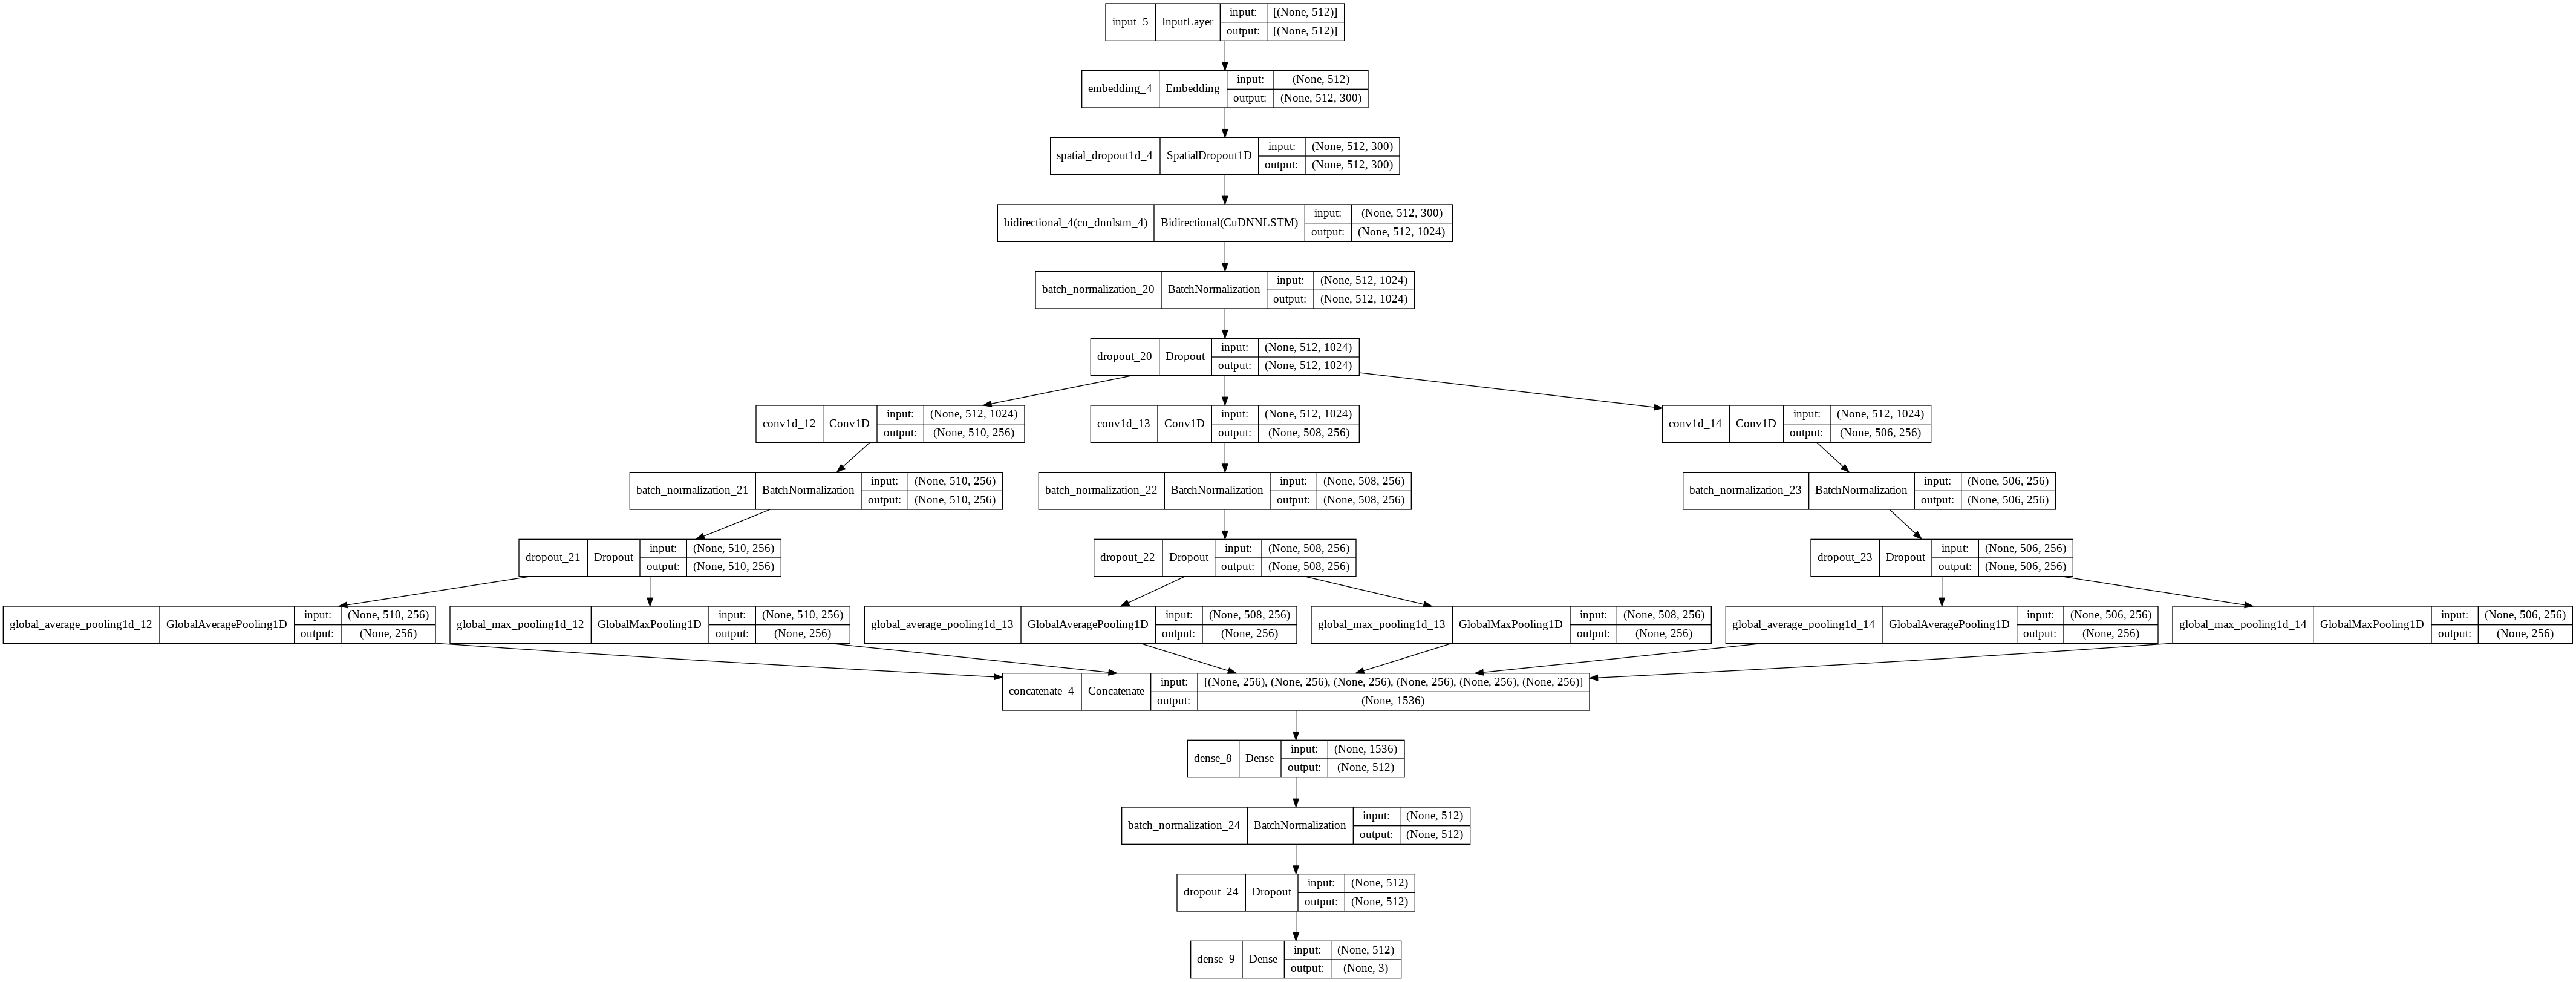

In [49]:
#Visualizing the model
plot_model(final_model_hybrid, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Results

Making predictions for the validation data

In [50]:
val_pred = final_model_hybrid.predict(X_val_indices)
print(classification_report(list(y_val['Ideology']), [list(i).index(max(i)) for i in val_pred]))

              precision    recall  f1-score   support

           0       0.73      0.57      0.64      1196
           1       0.79      0.79      0.79      1440
           2       0.64      0.78      0.70      1193

    accuracy                           0.72      3829
   macro avg       0.72      0.71      0.71      3829
weighted avg       0.72      0.72      0.72      3829



In [51]:
#Printing metrics for predictions
print("Confusion matrix: \n", metrics.confusion_matrix(list(y_val['Ideology']), [list(i).index(max(i)) for i in val_pred]))
print("\nAccuracy: ", metrics.accuracy_score(list(y_val['Ideology']), [list(i).index(max(i)) for i in val_pred]))
print("\nWeighted f1-score: ", metrics.f1_score(list(y_val['Ideology']), [list(i).index(max(i)) for i in val_pred], average='weighted'))

Confusion matrix: 
 [[ 680  167  349]
 [ 131 1142  167]
 [ 125  143  925]]

Accuracy:  0.7174196918255419

Weighted f1-score:  0.7150943757070022


Link to understand why weighted F1 and not macro F1:

https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1

# Predictions on the test set

Let's convert the text in test set to sequences

In [52]:
#Converting text to sequences
X_test_indices = tokenizer.texts_to_sequences(X_test['Title+Article'])

#Adding padding wherever the sequence length is < maxlen
X_test_indices = pad_sequences(X_test_indices, maxlen=512, padding='post')

X_test_indices.shape

(6381, 512)

Making predictions on the test data

In [53]:
test_pred = final_model_hybrid.predict(X_test_indices)
print(classification_report(list(y_test['Ideology']), [list(i).index(max(i)) for i in test_pred]))

              precision    recall  f1-score   support

           0       0.71      0.54      0.61      1993
           1       0.78      0.80      0.79      2399
           2       0.64      0.78      0.71      1989

    accuracy                           0.71      6381
   macro avg       0.71      0.71      0.70      6381
weighted avg       0.72      0.71      0.71      6381



In [54]:
#Printing metrics for predictions
print("Confusion matrix: \n", metrics.confusion_matrix(list(y_test['Ideology']), [list(i).index(max(i)) for i in test_pred]))
print("\nAccuracy: ", metrics.accuracy_score(list(y_test['Ideology']), [list(i).index(max(i)) for i in test_pred]))
print("\nWeighted f1-score: ", metrics.f1_score(list(y_test['Ideology']), [list(i).index(max(i)) for i in test_pred], average='weighted'))

Confusion matrix: 
 [[1078  330  585]
 [ 203 1922  274]
 [ 232  202 1555]]

Accuracy:  0.713837956433161

Weighted f1-score:  0.7100310399609737


Next, let's define a few methods that will help make predictions on smaller subsets of data.

In [55]:
#Creating a method to get subsets of a dataframe for validation
def subset_creator(df, labels_series, outlet_name, topic_name, ideology_label):

  if not ideology_label:
    #There is no ideology label in this branch

    
    if not topic_name:
      #No topic name in this branch

      #Converting text to sequences
      subset_tokenized = tokenizer.texts_to_sequences(df['Title+Article'][df['News_Outlet']==outlet_name])

      #Getting the indices for this subset of data
      subset_indices = list(df.index[df['News_Outlet']==outlet_name])

    else:
      #Topic name and outlet name are present in this branch

      #Converting text to sequences
      subset_tokenized = tokenizer.texts_to_sequences(df['Title+Article'][(df['News_Outlet']==outlet_name) & (df['Topic']==topic_name)])

      #Getting the indices for this subset of data
      subset_indices = list(df.index[(df['News_Outlet']==outlet_name) & (df['Topic']==topic_name)])


  else:
    #There is an ideology label in this branch

    #Defining a dictionary that maps news outlets to their political ideology
    outlet_ideology_dict = {"left": "ndtv|thewire|scroll|telegraph|thestatesman",
                          "centre": "TOI|theprint|IndiaToday|asiangage|freepressjournal",
                          "right": "opindia|NIE|oneindia|dailypioneer|indiatv"}

    if not topic_name:
      #No topic name in this branch

      #Converting text to sequences
      subset_tokenized = tokenizer.texts_to_sequences(df['Title+Article'][df['News_Outlet'].str.contains(outlet_ideology_dict.get(ideology_label))])

      #Getting the indices for this subset of data
      subset_indices = list(df.index[df['News_Outlet'].str.contains(outlet_ideology_dict.get(ideology_label))])

    else:
      #Topic name and outlet name are present in this branch

      #Converting text to sequences
      subset_tokenized = tokenizer.texts_to_sequences(df['Title+Article'][(df['News_Outlet'].str.contains(outlet_ideology_dict.get(ideology_label))) & (df['Topic']==topic_name)])

      #Getting the indices for this subset of data
      subset_indices = list(df.index[(df['News_Outlet'].str.contains(outlet_ideology_dict.get(ideology_label))) & (df['Topic']==topic_name)])


  #Adding padding wherever the sequence length is lesser than the input length
  subset_tokenized_and_padded = pad_sequences(subset_tokenized, maxlen=512, padding='post')

  #Getting the labels for the subset by using these indices
  subset_labels = labels_series[labels_series.index.isin(subset_indices)]

  return subset_tokenized_and_padded, subset_labels

In [56]:
#Creating a method to put the predictions in a dataframe
def pred_df_creator(preds_array, outlet_name, subs_ground):

  #Finding the highest score to make the prediction
  predictions_list = [list(i).index(max(i)) for i in preds_array]

  #Getting the ground truth for these predictions
  ground_truth_list = list(subs_ground['Ideology'])

  #Making a list of topics
  topics_list = X_test['Topic'][X_test['News_Outlet']==outlet_name]

  #Putting these lists in a dictionary
  data_for_df = {"Topic": topics_list, 
             "Predictions": predictions_list,
             "Ground Truth": ground_truth_list}

  #Creating a dataframe from the dictionary and returning it
  return pd.DataFrame(data_for_df)


In [57]:
#Method to compute metrics for each outlet
def outlet_metrics(outlet_df):

  accuracy = metrics.accuracy_score(outlet_df['Ground Truth'], outlet_df['Predictions'])
  f1_score = metrics.f1_score(outlet_df['Ground Truth'], outlet_df['Predictions'], average='weighted')
  confusion_matrix = metrics.confusion_matrix(outlet_df['Ground Truth'], outlet_df['Predictions'])

  return accuracy, f1_score, confusion_matrix

In [58]:
#Making a list of topics
topics_list = list(X_test['Topic'].unique())
topics_list

['article 370', 'caa', 'farm laws', 'rafale', 'sabarimala', 'section 377']

In [59]:
#Method to group and find metrics for each topic
def outlet_topic_scores(subset_df):

  #Initializing a list to store the outlet's scores
  outlet_scores = []

  #Looping through the list of topics
  for topic in topics_list:

    #Getting the metrics for each topic
    acc, f1, cm = outlet_metrics(subset_df[subset_df['Topic']==topic])

    #Appending the accuracy and f1 scores as a tuple
    outlet_scores.append((round(acc, 5), round(f1, 5)))

  return outlet_scores

### Predictions for each news outlet

In [60]:
#Initializing a dictionary
all_outlet_scores = {}

#### IndiaToday

In [61]:
#Setting the name of the outlet
outlet = 'IndiaToday'

In [62]:
#Getting the tokenized data for IndiaToday
subset_tokenized, subset_ground = subset_creator(X_test, y_test, outlet, None, None)

#Triggering garbage collection
gc.collect()

19392

In [63]:
#Making predictions for the subset
predictions_array = final_model_hybrid.predict(subset_tokenized)

In [64]:
#Putting the results in a dataframe
subs_df = pred_df_creator(predictions_array, outlet, subset_ground)

In [65]:
sub_accuracy, sub_f1_score, sub_conf_matrix = outlet_metrics(subs_df)
print("Performance metrics for {}\n".format(outlet))
print("Confusion matrix: \n{}".format(sub_conf_matrix))
print("Accuracy: ", sub_accuracy)
print("Weighted f1-score: ", sub_f1_score)

Performance metrics for IndiaToday

Confusion matrix: 
[[498  96 281]
 [  0   0   0]
 [  0   0   0]]
Accuracy:  0.5691428571428572
Weighted f1-score:  0.7254187909686818


In [66]:
#Storing the scores for this outlet in the dictionary
all_outlet_scores[outlet] = outlet_topic_scores(subs_df) + [round(sub_accuracy, 5)] + [round(sub_f1_score, 5)]

#### Scroll

In [67]:
#Setting the name of the outlet
outlet = 'scroll'

In [68]:
#Getting the tokenized data for Scroll
subset_tokenized, subset_ground = subset_creator(X_test, y_test, outlet, None, None)

#Triggering garbage collection
gc.collect()

780

In [69]:
#Making predictions for the subset
predictions_array = final_model_hybrid.predict(subset_tokenized)

In [70]:
#Putting the results in a dataframe
subs_df = pred_df_creator(predictions_array, outlet, subset_ground)

sub_accuracy, sub_f1_score, sub_conf_matrix = outlet_metrics(subs_df)
print("Performance metrics for {}\n".format(outlet))
print("Confusion matrix: \n{}".format(sub_conf_matrix))
print("Accuracy: ", sub_accuracy)
print("Weighted f1-score: ", sub_f1_score)

Performance metrics for scroll

Confusion matrix: 
[[  0   0   0]
 [ 26 813  14]
 [  0   0   0]]
Accuracy:  0.9531066822977726
Weighted f1-score:  0.9759903961584636


In [71]:
#Storing the scores for this outlet in the dictionary
all_outlet_scores[outlet] = outlet_topic_scores(subs_df) + [round(sub_accuracy, 5)] + [round(sub_f1_score, 5)]

#### OpIndia

In [72]:
#Setting the name of the outlet
outlet = 'opindia'

In [73]:
#Getting the tokenized data for OpIndia
subset_tokenized, subset_ground = subset_creator(X_test, y_test, outlet, None, None)

#Triggering garbage collection
gc.collect()

780

In [74]:
#Making predictions for the subset
predictions_array = final_model_hybrid.predict(subset_tokenized)

In [75]:
#Putting the results in a dataframe
subs_df = pred_df_creator(predictions_array, outlet, subset_ground)

sub_accuracy, sub_f1_score, sub_conf_matrix = outlet_metrics(subs_df)
print("Performance metrics for {}\n".format(outlet))
print("Confusion matrix: \n{}".format(sub_conf_matrix))
print("Accuracy: ", sub_accuracy)
print("Weighted f1-score: ", sub_f1_score)

Performance metrics for opindia

Confusion matrix: 
[[  0   0   0]
 [  0   0   0]
 [ 31  47 550]]
Accuracy:  0.8757961783439491
Weighted f1-score:  0.9337860780984718


In [76]:
#Storing the scores for this outlet in the dictionary
all_outlet_scores[outlet] = outlet_topic_scores(subs_df) + [round(sub_accuracy, 5)] + [round(sub_f1_score, 5)]

#### New Indian Express

In [77]:
#Setting the name of the outlet
outlet = 'NIE'

In [78]:
#Getting the tokenized data for NIE
subset_tokenized, subset_ground = subset_creator(X_test, y_test, outlet, None, None)

#Triggering garbage collection
gc.collect()

780

In [79]:
#Making predictions for the subset
predictions_array = final_model_hybrid.predict(subset_tokenized)

In [80]:
#Putting the results in a dataframe
subs_df = pred_df_creator(predictions_array, outlet, subset_ground)

sub_accuracy, sub_f1_score, sub_conf_matrix = outlet_metrics(subs_df)
print("Performance metrics for {}\n".format(outlet))
print("Confusion matrix: \n{}".format(sub_conf_matrix))
print("Accuracy: ", sub_accuracy)
print("Weighted f1-score: ", sub_f1_score)

Performance metrics for NIE

Confusion matrix: 
[[  0   0   0]
 [  0   0   0]
 [ 59  68 375]]
Accuracy:  0.7470119521912351
Weighted f1-score:  0.855188141391106


In [81]:
#Storing the scores for this outlet in the dictionary
all_outlet_scores[outlet] = outlet_topic_scores(subs_df) + [round(sub_accuracy, 5)] + [round(sub_f1_score, 5)]

#### The Wire

In [82]:
#Setting the name of the outlet
outlet = 'thewire'

In [83]:
#Getting the tokenized data for The Wire
subset_tokenized, subset_ground = subset_creator(X_test, y_test, outlet, None, None)

#Triggering garbage collection
gc.collect()

980

In [84]:
#Making predictions for the subset
predictions_array = final_model_hybrid.predict(subset_tokenized)

In [85]:
#Putting the results in a dataframe
subs_df = pred_df_creator(predictions_array, outlet, subset_ground)

sub_accuracy, sub_f1_score, sub_conf_matrix = outlet_metrics(subs_df)
print("Performance metrics for {}\n".format(outlet))
print("Confusion matrix: \n{}".format(sub_conf_matrix))
print("Accuracy: ", sub_accuracy)
print("Weighted f1-score: ", sub_f1_score)

Performance metrics for thewire

Confusion matrix: 
[[  0   0   0]
 [ 40 283  48]
 [  0   0   0]]
Accuracy:  0.7628032345013477
Weighted f1-score:  0.8654434250764527


In [86]:
#Storing the scores for this outlet in the dictionary
all_outlet_scores[outlet] = outlet_topic_scores(subs_df) + [round(sub_accuracy, 5)] + [round(sub_f1_score, 5)]

#### OneIndia

In [87]:
#Setting the name of the outlet
outlet = 'oneindia'

In [88]:
#Getting the tokenized data for OneIndia
subset_tokenized, subset_ground = subset_creator(X_test, y_test, outlet, None, None)

#Triggering garbage collection
gc.collect()

780

In [89]:
#Making predictions for the subset
predictions_array = final_model_hybrid.predict(subset_tokenized)

In [90]:
#Putting the results in a dataframe
subs_df = pred_df_creator(predictions_array, outlet, subset_ground)

sub_accuracy, sub_f1_score, sub_conf_matrix = outlet_metrics(subs_df)
print("Performance metrics for {}\n".format(outlet))
print("Confusion matrix: \n{}".format(sub_conf_matrix))
print("Accuracy: ", sub_accuracy)
print("Weighted f1-score: ", sub_f1_score)

Performance metrics for oneindia

Confusion matrix: 
[[  0   0   0]
 [  0   0   0]
 [ 72  32 364]]
Accuracy:  0.7777777777777778
Weighted f1-score:  0.8750000000000001


In [91]:
#Storing the scores for this outlet in the dictionary
all_outlet_scores[outlet] = outlet_topic_scores(subs_df) + [round(sub_accuracy, 5)] + [round(sub_f1_score, 5)]

#### Telegraph

In [92]:
#Setting the name of the outlet
outlet = 'telegraph'

In [93]:
#Getting the tokenized data for the Telegraph
subset_tokenized, subset_ground = subset_creator(X_test, y_test, outlet, None, None)

#Triggering garbage collection
gc.collect()

780

In [94]:
#Making predictions for the subset
predictions_array = final_model_hybrid.predict(subset_tokenized)

In [95]:
#Putting the results in a dataframe
subs_df = pred_df_creator(predictions_array, outlet, subset_ground)

sub_accuracy, sub_f1_score, sub_conf_matrix = outlet_metrics(subs_df)
print("Performance metrics for {}\n".format(outlet))
print("Confusion matrix: \n{}".format(sub_conf_matrix))
print("Accuracy: ", sub_accuracy)
print("Weighted f1-score: ", sub_f1_score)

Performance metrics for telegraph

Confusion matrix: 
[[  0   0   0]
 [ 44 305 102]
 [  0   0   0]]
Accuracy:  0.6762749445676275
Weighted f1-score:  0.8068783068783069


In [96]:
#Storing the scores for this outlet in the dictionary
all_outlet_scores[outlet] = outlet_topic_scores(subs_df) + [round(sub_accuracy, 5)] + [round(sub_f1_score, 5)]

#### ThePrint

In [97]:
#Setting the name of the outlet
outlet = 'theprint'

In [98]:
#Getting the tokenized data for ThePrint
subset_tokenized, subset_ground = subset_creator(X_test, y_test, outlet, None, None)

#Triggering garbage collection
gc.collect()

780

In [99]:
#Making predictions for the subset
predictions_array = final_model_hybrid.predict(subset_tokenized)

In [100]:
#Putting the results in a dataframe
subs_df = pred_df_creator(predictions_array, outlet, subset_ground)

sub_accuracy, sub_f1_score, sub_conf_matrix = outlet_metrics(subs_df)
print("Performance metrics for {}\n".format(outlet))
print("Confusion matrix: \n{}".format(sub_conf_matrix))
print("Accuracy: ", sub_accuracy)
print("Weighted f1-score: ", sub_f1_score)

Performance metrics for theprint

Confusion matrix: 
[[284 104  55]
 [  0   0   0]
 [  0   0   0]]
Accuracy:  0.6410835214446953
Weighted f1-score:  0.781292984869326


In [101]:
#Storing the scores for this outlet in the dictionary
all_outlet_scores[outlet] = outlet_topic_scores(subs_df) + [round(sub_accuracy, 5)] + [round(sub_f1_score, 5)]

#### NDTV

In [102]:
#Setting the name of the outlet
outlet = 'ndtv'

In [103]:
#Getting the tokenized data for NDTV
subset_tokenized, subset_ground = subset_creator(X_test, y_test, outlet, None, None)

#Triggering garbage collection
gc.collect()

780

In [104]:
#Making predictions for the subset
predictions_array = final_model_hybrid.predict(subset_tokenized)

In [105]:
#Putting the results in a dataframe
subs_df = pred_df_creator(predictions_array, outlet, subset_ground)

sub_accuracy, sub_f1_score, sub_conf_matrix = outlet_metrics(subs_df)
print("Performance metrics for {}\n".format(outlet))
print("Confusion matrix: \n{}".format(sub_conf_matrix))
print("Accuracy: ", sub_accuracy)
print("Weighted f1-score: ", sub_f1_score)

Performance metrics for ndtv

Confusion matrix: 
[[  0   0   0]
 [ 49 308  31]
 [  0   0   0]]
Accuracy:  0.7938144329896907
Weighted f1-score:  0.8850574712643678


In [106]:
#Storing the scores for this outlet in the dictionary
all_outlet_scores[outlet] = outlet_topic_scores(subs_df) + [round(sub_accuracy, 5)] + [round(sub_f1_score, 5)]

#### The Statesman

In [107]:
#Setting the name of the outlet
outlet = 'thestatesman'

In [108]:
#Getting the tokenized data for The Statesman
subset_tokenized, subset_ground = subset_creator(X_test, y_test, outlet, None, None)

#Triggering garbage collection
gc.collect()

780

In [109]:
#Making predictions for the subset
predictions_array = final_model_hybrid.predict(subset_tokenized)

In [110]:
#Putting the results in a dataframe
subs_df = pred_df_creator(predictions_array, outlet, subset_ground)

sub_accuracy, sub_f1_score, sub_conf_matrix = outlet_metrics(subs_df)
print("Performance metrics for {}\n".format(outlet))
print("Confusion matrix: \n{}".format(sub_conf_matrix))
print("Accuracy: ", sub_accuracy)
print("Weighted f1-score: ", sub_f1_score)

Performance metrics for thestatesman

Confusion matrix: 
[[  0   0   0]
 [ 44 213  79]
 [  0   0   0]]
Accuracy:  0.6339285714285714
Weighted f1-score:  0.7759562841530054


In [111]:
#Storing the scores for this outlet in the dictionary
all_outlet_scores[outlet] = outlet_topic_scores(subs_df) + [round(sub_accuracy, 5)] + [round(sub_f1_score, 5)]

#### Free Press Journal

In [112]:
#Setting the name of the outlet
outlet = 'freepressjournal'

In [113]:
#Getting the tokenized data for FPJ
subset_tokenized, subset_ground = subset_creator(X_test, y_test, outlet, None, None)

#Triggering garbage collection
gc.collect()

980

In [114]:
#Making predictions for the subset
predictions_array = final_model_hybrid.predict(subset_tokenized)

In [115]:
#Putting the results in a dataframe
subs_df = pred_df_creator(predictions_array, outlet, subset_ground)

sub_accuracy, sub_f1_score, sub_conf_matrix = outlet_metrics(subs_df)
print("Performance metrics for {}\n".format(outlet))
print("Confusion matrix: \n{}".format(sub_conf_matrix))
print("Accuracy: ", sub_accuracy)
print("Weighted f1-score: ", sub_f1_score)

Performance metrics for freepressjournal

Confusion matrix: 
[[111  42 141]
 [  0   0   0]
 [  0   0   0]]
Accuracy:  0.37755102040816324
Weighted f1-score:  0.5481481481481482


In [116]:
#Storing the scores for this outlet in the dictionary
all_outlet_scores[outlet] = outlet_topic_scores(subs_df) + [round(sub_accuracy, 5)] + [round(sub_f1_score, 5)]

#### Asian Age

In [117]:
#Setting the name of the outlet
outlet = 'asiangage'

In [118]:
#Getting the tokenized data for Asian Age
subset_tokenized, subset_ground = subset_creator(X_test, y_test, outlet, None, None)

#Triggering garbage collection
gc.collect()

980

In [119]:
#Making predictions for the subset
predictions_array = final_model_hybrid.predict(subset_tokenized)

In [120]:
#Putting the results in a dataframe
subs_df = pred_df_creator(predictions_array, outlet, subset_ground)

sub_accuracy, sub_f1_score, sub_conf_matrix = outlet_metrics(subs_df)
print("Performance metrics for {}\n".format(outlet))
print("Confusion matrix: \n{}".format(sub_conf_matrix))
print("Accuracy: ", sub_accuracy)
print("Weighted f1-score: ", sub_f1_score)

Performance metrics for asiangage

Confusion matrix: 
[[138  63  68]
 [  0   0   0]
 [  0   0   0]]
Accuracy:  0.5130111524163569
Weighted f1-score:  0.6781326781326781


In [121]:
#Storing the scores for this outlet in the dictionary
all_outlet_scores[outlet] = outlet_topic_scores(subs_df) + [round(sub_accuracy, 5)] + [round(sub_f1_score, 5)]

#### IndiaTV

In [122]:
#Setting the name of the outlet
outlet = 'indiatv'

In [123]:
#Getting the tokenized data for IndiaTV
subset_tokenized, subset_ground = subset_creator(X_test, y_test, outlet, None, None)

#Triggering garbage collection
gc.collect()

980

In [124]:
#Making predictions for the subset
predictions_array = final_model_hybrid.predict(subset_tokenized)

In [125]:
#Putting the results in a dataframe
subs_df = pred_df_creator(predictions_array, outlet, subset_ground)

sub_accuracy, sub_f1_score, sub_conf_matrix = outlet_metrics(subs_df)
print("Performance metrics for {}\n".format(outlet))
print("Confusion matrix: \n{}".format(sub_conf_matrix))
print("Accuracy: ", sub_accuracy)
print("Weighted f1-score: ", sub_f1_score)

Performance metrics for indiatv

Confusion matrix: 
[[  0   0   0]
 [  0   0   0]
 [ 52  22 155]]
Accuracy:  0.6768558951965066
Weighted f1-score:  0.8072916666666667


In [126]:
#Storing the scores for this outlet in the dictionary
all_outlet_scores[outlet] = outlet_topic_scores(subs_df) + [round(sub_accuracy, 5)] + [round(sub_f1_score, 5)]

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### Daily Pioneer

In [127]:
#Setting the name of the outlet
outlet = 'dailypioneer'

In [128]:
#Getting the tokenized data for Daily Pioneer
subset_tokenized, subset_ground = subset_creator(X_test, y_test, outlet, None, None)

#Triggering garbage collection
gc.collect()

980

In [129]:
#Making predictions for the subset
predictions_array = final_model_hybrid.predict(subset_tokenized)

In [130]:
#Putting the results in a dataframe
subs_df = pred_df_creator(predictions_array, outlet, subset_ground)

sub_accuracy, sub_f1_score, sub_conf_matrix = outlet_metrics(subs_df)
print("Performance metrics for {}\n".format(outlet))
print("Confusion matrix: \n{}".format(sub_conf_matrix))
print("Accuracy: ", sub_accuracy)
print("Weighted f1-score: ", sub_f1_score)

Performance metrics for dailypioneer

Confusion matrix: 
[[  0   0   0]
 [  0   0   0]
 [ 18  33 111]]
Accuracy:  0.6851851851851852
Weighted f1-score:  0.8131868131868134


In [131]:
#Storing the scores for this outlet in the dictionary
all_outlet_scores[outlet] = outlet_topic_scores(subs_df) + [round(sub_accuracy, 5)] + [round(sub_f1_score, 5)]

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### Times of India

In [132]:
#Setting the name of the outlet
outlet = 'TOI'

In [133]:
#Getting the tokenized data for TOI
subset_tokenized, subset_ground = subset_creator(X_test, y_test, outlet, None, None)

#Triggering garbage collection
gc.collect()

980

In [134]:
#Making predictions for the subset
predictions_array = final_model_hybrid.predict(subset_tokenized)

In [135]:
#Putting the results in a dataframe
subs_df = pred_df_creator(predictions_array, outlet, subset_ground)

sub_accuracy, sub_f1_score, sub_conf_matrix = outlet_metrics(subs_df)
print("Performance metrics for {}\n".format(outlet))
print("Confusion matrix: \n{}".format(sub_conf_matrix))
print("Accuracy: ", sub_accuracy)
print("Weighted f1-score: ", sub_f1_score)

Performance metrics for TOI

Confusion matrix: 
[[47 25 40]
 [ 0  0  0]
 [ 0  0  0]]
Accuracy:  0.41964285714285715
Weighted f1-score:  0.5911949685534591


In [136]:
#Storing the scores for this outlet in the dictionary
all_outlet_scores[outlet] = outlet_topic_scores(subs_df) + [round(sub_accuracy, 5)] + [round(sub_f1_score, 5)]

### Predictions for each ideology label

#### Centrist

In [137]:
#Getting the tokenized data for centrist outlets
subset_tokenized, subset_ground = subset_creator(X_test, y_test, None, None, 'centre')

#Triggering garbage collection
gc.collect()

780

In [138]:
#Making predictions
centre_pred = final_model_hybrid.predict(subset_tokenized)

In [139]:
#Calculating and storing metrics
centre_scores = [metrics.accuracy_score(list(subset_ground['Ideology']), [list(i).index(max(i)) for i in centre_pred]), 
                 metrics.f1_score(list(subset_ground['Ideology']), [list(i).index(max(i)) for i in centre_pred], average='weighted')]

#Printing metrics for predictions
print("Confusion matrix for centrist outlets: \n", metrics.confusion_matrix(list(subset_ground['Ideology']), [list(i).index(max(i)) for i in centre_pred]))
print("\nAccuracy for centrist outlets: ", centre_scores[0])
print("\nWeighted f1-score for centrist outlets: ", centre_scores[1])

Confusion matrix for centrist outlets: 
 [[1078  330  585]
 [   0    0    0]
 [   0    0    0]]

Accuracy for centrist outlets:  0.5408931259407928

Weighted f1-score for centrist outlets:  0.7020514490394009


#### Left wing

In [140]:
#Getting the tokenized data for left-win outlets
subset_tokenized, subset_ground = subset_creator(X_test, y_test, None, None, 'left')

#Triggering garbage collection
gc.collect()

779

In [141]:
#Making predictions
left_pred = final_model_hybrid.predict(subset_tokenized)

In [142]:
#Calculating and storing metrics
left_scores = [metrics.accuracy_score(list(subset_ground['Ideology']), [list(i).index(max(i)) for i in left_pred]), 
                 metrics.f1_score(list(subset_ground['Ideology']), [list(i).index(max(i)) for i in left_pred], average='weighted')]

#Printing metrics for predictions
print("Confusion matrix for left-wing outlets: \n", metrics.confusion_matrix(list(subset_ground['Ideology']), [list(i).index(max(i)) for i in left_pred]))
print("\nAccuracy for left-wing outlets: ", left_scores[0])
print("\nWeighted f1-score for left-wing outlets: ", left_scores[1])

Confusion matrix for left-wing outlets: 
 [[   0    0    0]
 [ 203 1922  274]
 [   0    0    0]]

Accuracy for left-wing outlets:  0.8011671529804085

Weighted f1-score for left-wing outlets:  0.889608886831752


#### Right wing

In [143]:
#Getting the tokenized data for right-wing outlets
subset_tokenized, subset_ground = subset_creator(X_test, y_test, None, None, 'right')

#Triggering garbage collection
gc.collect()

780

In [144]:
#Making predictions
right_pred = final_model_hybrid.predict(subset_tokenized)

In [145]:
#Calculating and storing metrics
right_scores = [metrics.accuracy_score(list(subset_ground['Ideology']), [list(i).index(max(i)) for i in right_pred]), 
                 metrics.f1_score(list(subset_ground['Ideology']), [list(i).index(max(i)) for i in right_pred], average='weighted')]


#Printing metrics for predictions
print("Confusion matrix for right-wing outlets: \n", metrics.confusion_matrix(list(subset_ground['Ideology']), [list(i).index(max(i)) for i in right_pred]))
print("\nAccuracy for right-wing outlets: ", right_scores[0])
print("\nWeighted f1-score for right-wing outlets: ", right_scores[1])

Confusion matrix for right-wing outlets: 
 [[   0    0    0]
 [   0    0    0]
 [ 232  202 1555]]

Accuracy for right-wing outlets:  0.7817998994469583

Weighted f1-score for right-wing outlets:  0.8775395033860045


### Summary of Results

#### Summary of results by news outlet

In [146]:
#Creating a new table
t1 = PrettyTable(['News Outlet', 'Article 370', 'CAA', 'Farm Laws', 'Rafale', 'Sabarimala', 'Section 377', 'Overall Accuracy', 'Overall F1 score'])

In [147]:
#Adding scores to the table
t1.add_row(['India Today'] +  all_outlet_scores.get('IndiaToday'))
t1.add_row(['Scroll'] +  all_outlet_scores.get('scroll'))
t1.add_row(['OpIndia'] +  all_outlet_scores.get('opindia'))
t1.add_row(['New Indian Express'] +  all_outlet_scores.get('NIE'))
t1.add_row(['The Wire'] +  all_outlet_scores.get('thewire'))
t1.add_row(['One India'] +  all_outlet_scores.get('oneindia'))
t1.add_row(['Telegraph'] +  all_outlet_scores.get('telegraph'))
t1.add_row(['ThePrint'] +  all_outlet_scores.get('theprint'))
t1.add_row(['NDTV'] +  all_outlet_scores.get('ndtv'))
t1.add_row(['The Statesman'] +  all_outlet_scores.get('thestatesman'))
t1.add_row(['Free Press Journal'] +  all_outlet_scores.get('freepressjournal'))
t1.add_row(['Asian Age'] +  all_outlet_scores.get('asiangage'))
t1.add_row(['India TV'] +  all_outlet_scores.get('indiatv'))
t1.add_row(['Daily Pioneer'] +  all_outlet_scores.get('dailypioneer'))
t1.add_row(['Times of India'] +  all_outlet_scores.get('TOI'))

#Formatting the table to only display two decimal points
t1.float_format = '.5'

#Changing the alignment of columns
t1.align = "r"
t1.align["News Outlet"] = "l"

print(t1)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+
| News Outlet        |        Article 370 |                CAA |          Farm Laws |             Rafale |         Sabarimala |        Section 377 | Overall Accuracy | Overall F1 score |
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+
| India Today        | (0.55512, 0.71392) |   (0.625, 0.76923) | (0.59545, 0.74644) | (0.52846, 0.69149) |  (0.3871, 0.55814) | (0.70833, 0.82927) |          0.56914 |          0.72542 |
| Scroll             |  (0.9457, 0.97209) | (0.95299, 0.97593) | (0.97927, 0.98953) | (0.94792, 0.97326) | (0.95238, 0.97561) |  (0.8913, 0.94253) |          0.95311 |          0.97599 |
| OpIndia            | (0.88816, 0.94077) |  (0.92511, 0.9611) | 

#### Summary of results by ideology

In [148]:
#Creating a new table
t2 = PrettyTable(['Ideology', 'Accuracy', 'F1 score'])

In [149]:
#Adding scores to the table
t2.add_row(['Centre'] + [centre_scores[0]] + [centre_scores[1]])
t2.add_row(['Left'] + [left_scores[0]] + [left_scores[1]])
t2.add_row(['Right'] + [right_scores[0]] + [right_scores[1]])


#Formatting the table to only display two decimal points
t2.float_format = '.5'

#Changing the alignment of columns
t2.align = "r"
t2.align["News Outlet"] = "l"

print(t2)

+----------+----------+----------+
| Ideology | Accuracy | F1 score |
+----------+----------+----------+
|   Centre |  0.54089 |  0.70205 |
|     Left |  0.80117 |  0.88961 |
|    Right |  0.78180 |  0.87754 |
+----------+----------+----------+
